In [8]:
# Get all the variables, classes and functions we defined in the previous lessons
from vars.week3 import *
from vars.week4 import *


# 5. Improving the training loop
## 5.1 Adaptive learning rate
With the device selection out of the way, let's have a look at how we can improve the model's performance by modifiying one of its hyperparameters. You can think of hyperparameters as arguments to the model's training function. The reason they're not simply called parameters is because that word is reserved for the weights and biases within the network itself. In particular, we'll look at the model's learning rate.  

From the lectures, you may remember that the learning rate of a model is a measure of how far the weights are allowed to 'step' in the direction of the gradient. If the LR is constant and large, (as was the case in our last example) the model takes large steps towards the optimal solution. This is not ideal: as the weights of the model start to converge on the solution, the large steps taken by the optimiser may undershoot it. A constant, small LR is not ideal either: the tiny steps taken by the optimiser mean that the model would take a very long time to converge, or learn. Therefore, we want a combination of these two: relatively large LR early on in the training (to quickly get in the neighbourhood of the optimal solution) and a progressively smaller LR as we get closer and closer to the solution (so that we don't undershoot it).   

### 5.1.1 ExponentialLR
In Pytorch, this is handled by a group of classes called learning rate schedulers. To demonstrate how they work, we will be using the `ExponentialLR` scheduler, which applies the following function to reduce the learning rate every epoch:    

$l_{epoch} = g * l_{epoch - 1}$ 

where 
* $l_{epoch}$ is the new learning rate to be set for the next epoch,
* $g$ is the hyperparameter gamma, which controls how quickly the learning rate decays, and
* $l_{epoch - 1}$ is the learning rate of the current epoch

_Note: The initial LR chosen for this exercise was actually relatively high and is only intended to exaggerate the difference an adaptive LR scheduler makes. Real applications initialise their LRs to something many orders of magnitude smaller_

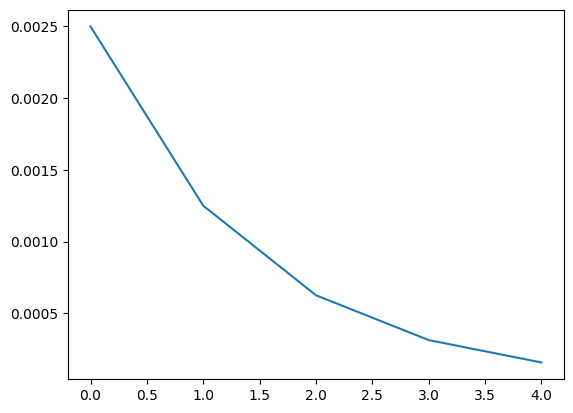

In [16]:
from torch.optim.lr_scheduler import ExponentialLR
# Exponential LR visualisation

model = get_simple_linear_net()
optimizer = SGD(model.parameters(),lr=learning_rate)
gamma = 0.5 #gama is multiplied by the lr every epoch, decreasing the learning rate every time
schd = ExponentialLR(optimizer,gamma)

lrs = []
for i in range(epochs):
    schd.step()
    lrs.append(schd.get_last_lr())

plt.plot(lrs)

### 5.1.2 Modifying the training loop 
Let's apply what we've learned about adaptive LRs to our training loop. We update our `train_model` function to accept a new parameter `lr_scheduler`, which is an instance of the `ExponentialLR` class. You can of course use any LR scheduler in the `torch.optim.lr_scheduler` module, and some may be better suited to a particular task than others. `ExponentialLR` was chosen here for its simplicity

In [17]:
def train_model_gpu_lr(model, epochs, train_dl, optimiser, lr_scheduler):
    msg = ""
    for epoch in range(epochs):
        total_steps = len(train_dl)
        correct = 0
        total = 0

        model.train()
        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)
            
            image_batch = image_batch.to(DEVICE)
            label_batch = label_batch.to(DEVICE)
            
            output = model(image_batch)
            losses = nn.CrossEntropyLoss()(output, label_batch)
                        
            optimiser.zero_grad()
            losses.backward()
            optimiser.step()  
            
            preds = torch.argmax(output, dim=1)
            correct += int(torch.eq(preds, label_batch).sum())
            total += batch_sz
            minibatch_accuracy = 100 * correct / total

            #### Fancy printing stuff, you can ignore this! ######
            if (batch_num + 1) % 5 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps}], Loss: {losses.item():.5f}, Acc: {minibatch_accuracy:.5f}, LR: {lr_scheduler.get_last_lr()[0]:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)
            #### Fancy printing stuff, you can ignore this! ######

        # Call the LR scheduler every epoch so that it can update the learning rate used by the optimiser
        lr_scheduler.step()

In [34]:
eps = 30
gamma =0.9
# load data split from  DATA_PATH variable
train_dl, val_dl, test_dl = load_data(DATA_PATH,batch_sz=batch_sz)
# instantiate simple network
network = get_simple_linear_net()
# instantiate SGD optimiser
optim = SGD(network.parameters(), lr=learning_rate)
# instantiate ExponentialLR learning rate scheduler
lr_sch = ExponentialLR(optim,gamma)
# move network to DEVICE
network = network.to(DEVICE)
# call train function
train_model_gpu_lr(model=network, epochs=eps, train_dl=train_dl, optimiser=optim, lr_scheduler=lr_sch)


### 5.1.3 Debrief: Simple model with adaptive LR
The model should now be performing at above 90% accuracy. Getting closer, but not quite there yet!

## 5.2 The convolutional network
Back to improving model performance - we're currently hovering around 90%, so let's modify our simple linear network so that the input is a convolutional layer. This is more suited to image data than a simple fully connected layer like we had in the previous few examples 

In [ ]:
def get_simple_conv_net():
    pass

# Print the model's summary (you caweek-5-improving-training-loop.ipynbn check week 4's lesson for a reminder
# on how to do this)
...

In [ ]:
# Because the model now expects a 3-d input (channels * width * height), we need to modify our training function:
def train_model_gpu_lr_conv(model, epochs, train_dl, optimiser, lr_scheduler):
    msg = ""
    for epoch in range(epochs):
        total_steps = len(train_dl)
        correct = 0
        total = 0
week-5-improving-training-loop.ipynb
        model.train()
        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)
            label_batch = label_batch.to(DEVICE)
            image_batch = image_batch.to(DEVICE) # 1 channel, 28 * 28 pixels
            output = model(image_batch)
            losses = nn.CrossEntropyLoss()(output, label_batch)
                        
            optimiser.zero_grad()
            losses.backward()
            optimiser.step()  
            
            preds = torch.argmax(output, dim=1)
            correct += int(torch.eq(preds, label_batch).sum())
            total += batch_sz
            minibatch_accuracy = 100 * correct / total

            #### Fancy printing stuff, you can ignore this! ######
            if (batch_num + 1) % 5 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps}], Loss: {losses.item():.5f}, Acc: {minibatch_accuracy:.5f}, LR: {lr_scheduler.get_last_lr()[0]:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)
            #### Fancy printing stuff, you can ignore this! ######
            
        lr_scheduler.step()

In [ ]:
# load data split from DATA_PATH variable
train_dl, val_dl, test_dl = ...
# instantiate the simple convolutional network
network = ...
# instantiate SGD optimiser
optim = ...
# instantiate exponential learning rate scheduler
lr_sch = ...
# move model to DEVICE
network = ...
# call latest training function
...



### 5.2.1 Debrief: Simple Conv net 
You should now see a significantly higher accuracy (around 98 - 99%). However, training accuracy is only half the story. We know now that the model can predict with very high accuracy what digit it's looking at as long as it's already seen it before. But what if it has to make a prediction on a number it's not seen before?

## 5.3 The validation epoch
This is the reason we split out dataset into train, validation and test splits earlier. At the end of every train epoch, we additionally run a validation epoch to assure ourselves that the model is actually learning a decent representation of the dataset in general, and not over-fitting on the training data. Once again, we must make the necessary changes to our training function (getting to be a bit of a mouthful now :D). The `train_dl` argument has been replaced by a dictionary that holds all the dataloaders associated with our dataset, so that we can reference them by name in the function body without passing a lot of arguments to it. It is generally a good idea to wrap closely related arguments in some sort of structure like a dictionary - leads to less cluttered function definitions.

In [ ]:
dataloaders = ...

def train_model_gpu_lr_conv_valid(model, epochs, dataloaders, optimiser, lr_scheduler):
    msg = ""
    for epoch in range(epochs):        
        #######################TRAINING STEP###################################
        model.train()  # set model to training mode 
        # select train dataloader
                
        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)
            label_batch = label_batch.to(DEVICE)
            image_batch = image_batch.to(DEVICE).reshape(batch_sz, 1, 28, 28) 
            output = model(image_batch)
            losses = nn.CrossEntropyLoss()(output, label_batch)
                        
            optimiser.zero_grad()
            losses.backward()
            optimiser.step()
            
            preds_train = torch.argmax(output, dim=1)
            correct_train += int(torch.eq(preds_train, label_batch).sum())
            total_train += batch_sz
            minibatch_accuracy_train = 100 * correct_train / total_train
            
            #### Fancy printing stuff, you can ignore this! ######
            if (batch_num + 1) % 5 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps_train}], Loss: {losses.item():.5f}, Acc: {minibatch_accuracy_train:.5f}, LR: {lr_scheduler.get_last_lr()[0]:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)
            #### Fancy printing stuff, you can ignore this! ######
        lr_scheduler.step()
        ########################################################################
        print("") # Create newline between progress bars
        #######################VALIDATION STEP##################################
        ########################################################################
        print("")  # Create newline between progress bars
        

            
            
        

In [ ]:
# instantiate simple conv net
network = ...
# instantiate SGD optimiser
optim = ...
# instantiate exponential LR scheduler
lr_sch = ...
# move model to DEVICE
network = ...
# call latest training function
...


### 5.3.1 Debrief: Simple Conv net with validation 
You will notice that the evaluation accuracy lags behind the training accuracy ever so slightly. This is normal, and to be expected: it shows the model is not quite as good at predicting unseen numbers as it is at predicting ones it's seen before, although it's pretty close! The gap between the train and val metrics is called the generlisation gap and is a measure of how well the model performs on unseen data.